# **Homework 6**

In [33]:
from functools import partial
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

import sys
if '../cmds/' not in sys.path:
    sys.path.append('../cmds/')

import warnings
warnings.filterwarnings("ignore")

In [34]:
raw_data = pd.read_excel('momentum_data.xlsx',sheet_name = None)
sheets = list(raw_data.keys())

ff_factors = raw_data[sheets[1]].set_index('Date')
momentum = raw_data[sheets[2]].set_index('Date')
mom_deciles = raw_data[sheets[3]].set_index('Date')
tercile_port = raw_data[sheets[4]].set_index('Date')
rf = raw_data[sheets[5]].set_index('Date')

ff_factors['UMD'] = momentum['UMD']

#### Functions

In [35]:
def summary_statistics_annualized(returns, annual_factor = 12):
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    summary_statistics['VaR (0.05)'] = returns.quantile(.05, axis = 0)
    summary_statistics['CVaR (0.05)'] = returns[returns <= returns.quantile(.05, axis = 0)].mean()   
    return summary_statistics

## **2 Investigating Momentum**

### **2.1.(a)**

In [36]:
periods = [['1927', '2024'], ['1927', '1993'], ['1994', '2008'], ['2009', '2024']]
summary_col_names = ['Mean','Vol','Sharpe','Skewness']
res = []
for period in periods:
    temp = momentum.loc[period[0]:period[1]]
    temp_ff = ff_factors.loc[period[0]:period[1]]
    summary = summary_statistics_annualized(temp, annual_factor = 12)[summary_col_names]
    summary['mkt_corr'] = temp_ff.corr().loc['MKT',['UMD']]
    summary['val_corr'] = temp_ff.corr().loc['HML',['UMD']]
    summary = summary.T.iloc[:,0].rename(f'{period[0]} - {period[1]}')
    res.append(summary)
summary  = pd.concat(res, axis=1).T
summary

,Mean,Vol,Sharpe,Skewness,mkt_corr,val_corr
1927 - 2024,0.075328,0.162508,0.463534,-2.990493,-0.344284,-0.406410
1927 - 1993,0.090081,0.160003,0.562992,-3.808207,-0.362496,-0.495002
1994 - 2008,0.104373,0.175551,0.594548,-0.582038,-0.234519,-0.129361
2009 - 2024,-0.015092,0.158467,-0.095238,-2.691022,-0.367588,-0.320924


### **2.1.(b)**

#### Based on these subsample statistics, the momentum doesn't change much in the most of the periods(with mean: 0.090, 0.104), but it shows negative return after 2009(-0.015).

### **2.1.(c)**

#### Yes, because Momentum performance has achieved relatively significant positive returns (0.075328) in the overall time period. Additionally, due to its low correlation with market portfolio returns, it can effectively be used to diversify risk. Even though the mean returns to momentum are actually near zero due to transaction costs, it is still valuable because of its low correlation with other factors.

In [37]:
tercile_port

,SMALL LoPRIOR,ME1 PRIOR2,SMALL HiPRIOR,BIG LoPRIOR,ME2 PRIOR2,BIG HiPRIOR
Date,,,,,,
1927-01-31,0.0008,0.0357,0.0040,-0.0040,0.0026,0.0000
1927-02-28,0.0701,0.0648,0.0551,0.0727,0.0380,0.0447
1927-03-31,-0.0346,-0.0288,-0.0206,-0.0357,-0.0018,0.0226
1927-04-30,-0.0075,-0.0048,0.0332,-0.0272,0.0075,0.0181
1927-05-31,0.0248,0.1115,0.0683,0.0552,0.0496,0.0718
...,...,...,...,...,...,...
2024-05-31,0.0571,0.0483,0.0457,0.0549,0.0287,0.0660
2024-06-30,-0.0241,-0.0138,-0.0311,0.0292,0.0225,0.0542
2024-07-31,0.0900,0.1066,0.1091,0.0474,0.0320,-0.0202


### **2.2.(a)**

In [38]:
mom_long = (tercile_port['BIG HiPRIOR'] + tercile_port['SMALL HiPRIOR'])/2 - rf['RF']
mom_names = ['long_and_short','long_only']

temp = ff_factors.copy().rename(columns={'UMD':'long_and_short'})
temp['long_only']  = mom_long
summary = summary_statistics_annualized(temp.loc["1994":, mom_names])[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', mom_names]
summary['val_corr'] = temp.corr().loc['HML', mom_names]
summary

,Mean,Vol,Sharpe,Skewness,mkt_corr,val_corr
long_and_short,0.043184,0.167682,0.257534,-1.445951,-0.344284,-0.406410
long_only,0.117195,0.178410,0.656885,-0.444802,0.935817,0.210531


### **2.2.(b)**

#### Yes, long-only momentum can achieve significantly higher mean returns with similar volatility.

### **2.2.(c)**

#### Considering market and value premia, the long-only momentum strategy has a correlation coefficient with the market portfolio as high as 0.936. This indicates that it does not effectively hedge against market risk and cannot be considered diversifying.

### **2.2.(d)**

<Axes: xlabel='Date'>

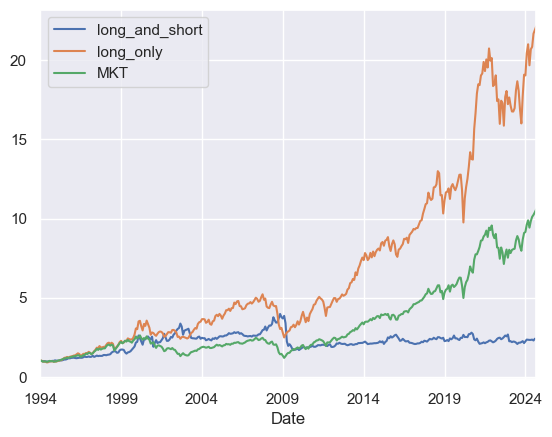

In [39]:
(1 + temp[mom_names + ['MKT']].loc['1994':]).cumprod().plot()

### **2.3.(a)**

In [40]:
ls_1decile = mom_deciles['Hi PRIOR'] - mom_deciles['Lo PRIOR']
ls_3decile = mom_deciles.iloc[:,-3:].mean(axis = 1) - mom_deciles.iloc[:,:3].mean(axis = 1)
ls_5decile = mom_deciles.iloc[:,-5:].mean(axis = 1) - mom_deciles.iloc[:,:5].mean(axis = 1)

ls_names = ['mom_D1','mom_D3','mom_D5']
temp = ff_factors.copy()
temp[ls_names] = pd.concat([ls_1decile, ls_3decile, ls_5decile], axis=1)
summary = summary_statistics_annualized(temp.loc["1994":, ls_names + ['UMD']])[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', ls_names + ['UMD']]
summary['val_corr'] = temp.corr().loc['HML', ls_names + ['UMD']]
summary

,Mean,Vol,Sharpe,Skewness,mkt_corr,val_corr
mom_D1,0.082010,0.299035,0.274248,-1.304629,-0.369000,-0.404373
mom_D3,0.028551,0.193383,0.147638,-1.345002,-0.381904,-0.396644
mom_D5,0.016411,0.133990,0.122480,-1.415925,-0.361677,-0.391819
UMD,0.043184,0.167682,0.257534,-1.445951,-0.344284,-0.406410


### **2.3.(b)**

#### Statistical results indicate that the trading strategy of going long the top 1 decile and short the bottom 1 decile can achieve the highest mean return (0.082) while generating higher return volatility (0.299), consistent with the theoretical trade-offs we discussed in class.

### **2.3.(c)**

#### When balancing mean returns and risk, I tend to choose the strategy with a higher Sharpe ratio, which is the 1-decile construction.

### **2.3.(d)**

#### When comparing the statistical metrics of the mom_D3 with the UMD, their performances are indeed very similar. However, mom_D3 performs slightly worse than the Fama-French construction in both mean return and volatility. The Fama-French construction allows for a balance between small and large stocks, whereas momD3 may overly favor one type, leading to the exclusion of excellent stocks in the other type.

### **2.4.(a)**

In [41]:
mom_small = tercile_port['SMALL HiPRIOR'] - tercile_port['SMALL LoPRIOR']
mom_large = tercile_port['BIG HiPRIOR'] - tercile_port['BIG LoPRIOR']

mom_size_name = ['Small_stocks','Big_stocks']
temp = ff_factors.copy()
temp[mom_size_name] = pd.concat([mom_small, mom_large], axis=1)
summary = summary_statistics_annualized(temp.loc["1994":, mom_size_name + ['UMD']])[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', mom_size_name + ['UMD']]
summary['val_corr'] = temp.corr().loc['HML', mom_size_name + ['UMD']]
summary.rename({'UMD':'All_stocks'})

,Mean,Vol,Sharpe,Skewness,mkt_corr,val_corr
Small_stocks,0.063200,0.169633,0.372569,-1.763649,-0.331534,-0.388244
Big_stocks,0.023177,0.182458,0.127028,-0.879114,-0.324900,-0.386341
All_stocks,0.043184,0.167682,0.257534,-1.445951,-0.344284,-0.406410


### **2.4.(b)**

#### Statistical results indicate that the small stock momentum portfolio indeed outperforms the large stock momentum portfolio, but the latter still generates positive excess returns.

### **2.5**

#### AQR's retail product uses a long only approach which leads to a higher correlation with the Market and has less diversification benefits compared to the benchmark index or Fama-French momentum factor.
#### Quarterly rebalancing might make the portfolio diverge from the benchmark index and Fama-French momentum factor.

## **4 Estimating Underperformance**

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import scipy.stats as stats
import arch
import warnings
warnings.filterwarnings("ignore")
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
sns.set_theme()

In [51]:
data = pd.read_excel('barnstable_analysis_data.xlsx', sheet_name=1).set_index('date').fillna(method = 'ffill')
data['excess_returns'] = data['SPX'] - data['TB1M'] 
rets = data['excess_returns']
data

,SPX,TB1M,excess_returns
date,,,
1926-01-30,-0.001783,0.003061,-0.004844
1926-02-27,-0.033297,0.002612,-0.035909
1926-03-31,-0.057708,0.002601,-0.060309
1926-04-30,0.038522,0.002270,0.036252
1926-05-28,0.013623,0.002691,0.010932
...,...,...,...
2024-05-31,0.049431,0.004465,0.044966
2024-06-28,0.037199,0.004467,0.032732
2024-07-31,0.012148,0.004464,0.007684


### **4.1.(a)**

In [52]:
agg_years = [(1965, 1999), (2000, 2024), (1926, 2024)]
def calc_analytics_by_year(data, agg_years):
    res = []
    for y in agg_years:
        sub = data.loc[str(y[0]):str(y[1])]
        res.append({'mean': sub.mean() * 12, 'vol': sub.std() * np.sqrt(12)})
    return pd.DataFrame(res, index = [f'{i[0]} - {i[1]}' for i in agg_years]).stack()

sum_stats = data.apply(calc_analytics_by_year, agg_years = agg_years).T
log_sum_stats = np.log(1 + data).apply(calc_analytics_by_year, agg_years = agg_years).T

res_stats = pd.concat([sum_stats, log_sum_stats])
res_stats.index = pd.MultiIndex.from_product([['levels','logs'], sum_stats.index.to_list()])
res_stats.style.format('{:,.2%}')

### **4.1.(b)**

#### Compared to the sub-samples, the full sample period achieved higher excess returns (excess_rm) along with higher volatility. Meanwhile, the S&P 500 (rm) and 1-month T-bills (rf) performed best during the sub-sample period of 1965-1999, exhibiting the highest Sharpe ratios.

#### Full sample estimates are significantly different for the excess returns, this is because of the low risk-free rate during that period. The log returns show lower mean returns as expected.

#### Compared to the log statistics, the level statistics do not differ significantly. In the full sample, they exhibit higher mean and volatility, while in the sub-samples, they have higher mean and nearly equal or even lower volatility.

### **4.2.(a)**

$$
\begin{aligned}
\operatorname{Pr}\left[R_{t, t+h}^M<R_{t, t+h}^f\right] &= \operatorname{Pr}\left[\log (R_{t, t+h}^M) - \log (R_{t, t+h}^f) < 0 \right] = \operatorname{Pr}\left[ \mathrm{r}_{t, t+h}^M - \mathrm{r}_{t, t+h}^f < 0 \right] \\
&= \operatorname{Pr}\left[ \sum_{i=t}^{t+h}{\mathrm{r}}_{i}^M - \sum_{i=t}^{t+h}{\mathrm{r}}_{i}^f < 0 \right] = \operatorname{Pr}\left[ \sum_{i=t}^{t+h}(\mathrm{r}_{i}^M - \mathrm{r}_{i}^f) < 0 \right] \\
&= \operatorname{Pr}\left[ \sum_{i=t}^{t+h}\tilde{\mathrm{r}}_{i} < 0 \right] = \operatorname{Pr}\left[ \tilde{\mathrm{r}}_{t, t+h} < 0 \right] \\
\end{aligned}
$$

Let annualized mean and volatility of log excess return as $\mu$ and $\sigma$, then we can see

$$
\tilde{\mathrm{r}}_{t, t+h} \sim \mathcal{N}\left(h\mu, h\sigma^2\right)
$$

As such,

$$
\operatorname{Pr}\left[ \tilde{\mathrm{r}}_{t, t+h} < 0 \right] = 
\operatorname{Pr}\left[ Z < \frac{-h\mu}{\sqrt{h}\sigma} \right] \\
= \Phi_{\mathcal{N}}\left(-\sqrt{h}\frac{\mu}{\sigma}\right)
$$

### **4.2.(b)**

In [53]:
def prob(mu, sigma, h):
    return norm.cdf(np.sqrt(h)*mu/sigma)

mu, sigma = res_stats['1965 - 1999'].loc[('logs', 'excess_returns')]

print(f'SPX underperforming RF in the next 15 years after 1999: {prob(mu = -mu, sigma = sigma, h = 15):,.2%}')

print(f'SPX underperforming RF in the next 30 years after 1999: {prob(mu = -mu, sigma = sigma, h = 30):,.2%}')

SPX underperforming RF in the next 15 years after 1999: 7.42%
SPX underperforming RF in the next 30 years after 1999: 2.05%


### **4.2.(c)**

<Axes: >

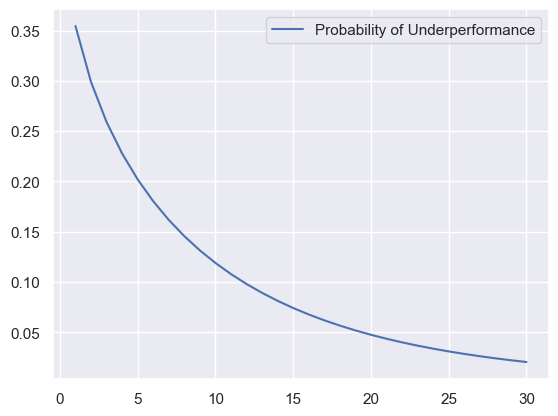

In [54]:
h = np.arange(30) + 1
probs = pd.DataFrame([prob(-mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot()

### **4.3**

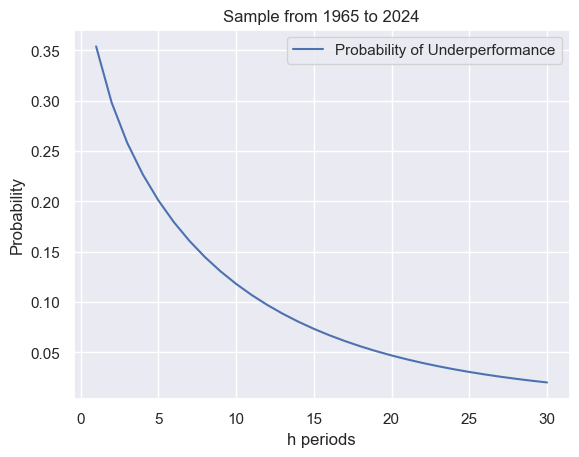

In [58]:
mu = np.log(1+rets.loc['1965':'2024']).mean() * 12
sigma = np.log(1+rets.loc['1965':'2024']).std() * np.sqrt(12)
h = np.arange(30)+1

probs = pd.DataFrame([prob(-mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot(title = 'Sample from 1965 to 2024', ylabel = 'Probability', xlabel = 'h periods')
plt.show()

### **4.4**

In [57]:
mu = res_stats[('1965 - 1999', 'mean')].loc[('logs', 'SPX')] - res_stats[('2000 - 2024', 'mean')].loc[('logs', 'SPX')]
sigma = res_stats[('1965 - 1999', 'vol')].loc[('logs', 'SPX')]

print(f"Probability of underperformance in 2000-2024: {prob(-mu, sigma, 24):,.2%}")

Probability of underperformance in 2000-2024: 8.27%
